# VAE Image Generation

In [45]:
!pip install keras-nightly keras-hub-nightly --upgrade -q

In [46]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [47]:
import keras
from keras import layers

In [49]:
latent_dim = 2

image_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
    image_inputs
)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(image_inputs, [z_mean, z_log_var], name="encoder")

In [50]:
encoder.summary(line_length=80)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9         │ (None, 28, 28, 1) │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_83 (Conv2D)    │ (None, 14, 14,    │         320 │ input_layer_9[0][… │
│                       │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_84 (Conv2D)    │ (None, 7, 7, 64)  │      18,496 │ conv2d_83[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ flatten_1 (Flatten)   │ (None, 3136)      │           0 │ conv2d_84[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ dense_2 (Dense)       │ (None, 16)        │      50,192 │ flatten_1[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ z_mean (Dense)        │ (None, 2)         │          34 │ dense_2[0][0]      │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ z_log_var (Dense)     │ (None, 2)         │          34 │ dense_2[0][0]      │
└───────────────────────┴───────────────────┴─────────────┴────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from keras import ops

class Sampler(keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator()
        self.built = True

    def call(self, z_mean, z_log_var):
        batch_size = ops.shape(z_mean)[0]
        z_size = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(
            (batch_size, z_size), seed=self.seed_generator
        )
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [52]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
    x
)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(
    x
)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [53]:
decoder.summary(line_length=80)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)       │ (None, 2)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 3136)             │         9,408 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ reshape_1 (Reshape)               │ (None, 7, 7, 64)         │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_transpose_2                │ (None, 14, 14, 64)       │        36,928 │
│ (Conv2DTranspose)                 │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_transpose_3                │ (None, 28, 28, 32)       │        18,464 │
│ (Conv2DTranspose)                 │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)                │ (None, 28, 28, 1)        │           289 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        return self.encoder(inputs)

    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        original = x
        z_mean, z_log_var = y_pred
        reconstruction = self.decoder(self.sampler(z_mean, z_log_var))

        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (
            1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)
        )
        total_loss = reconstruction_loss + ops.mean(kl_loss)

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss

In [55]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - kl_loss: 1.9474 - loss: 211.5551 - reconstruction_loss: 209.6008
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - kl_loss: 2.2836 - loss: 186.9352 - reconstruction_loss: 184.6529
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 2.1924 - loss: 182.4605 - reconstruction_loss: 180.2665
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 2.6051 - loss: 178.0353 - reconstruction_loss: 175.4313
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.4074 - loss: 168.1017 - reconstruction_loss: 164.6928
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.8217 - loss: 160.8461 - reconstruction_loss: 157.0239
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.8524 - loss: 158.4322 - reconstruction_loss: 154.5788
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.8666 - loss: 156.7376 - reconstruction_loss: 152.8708
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

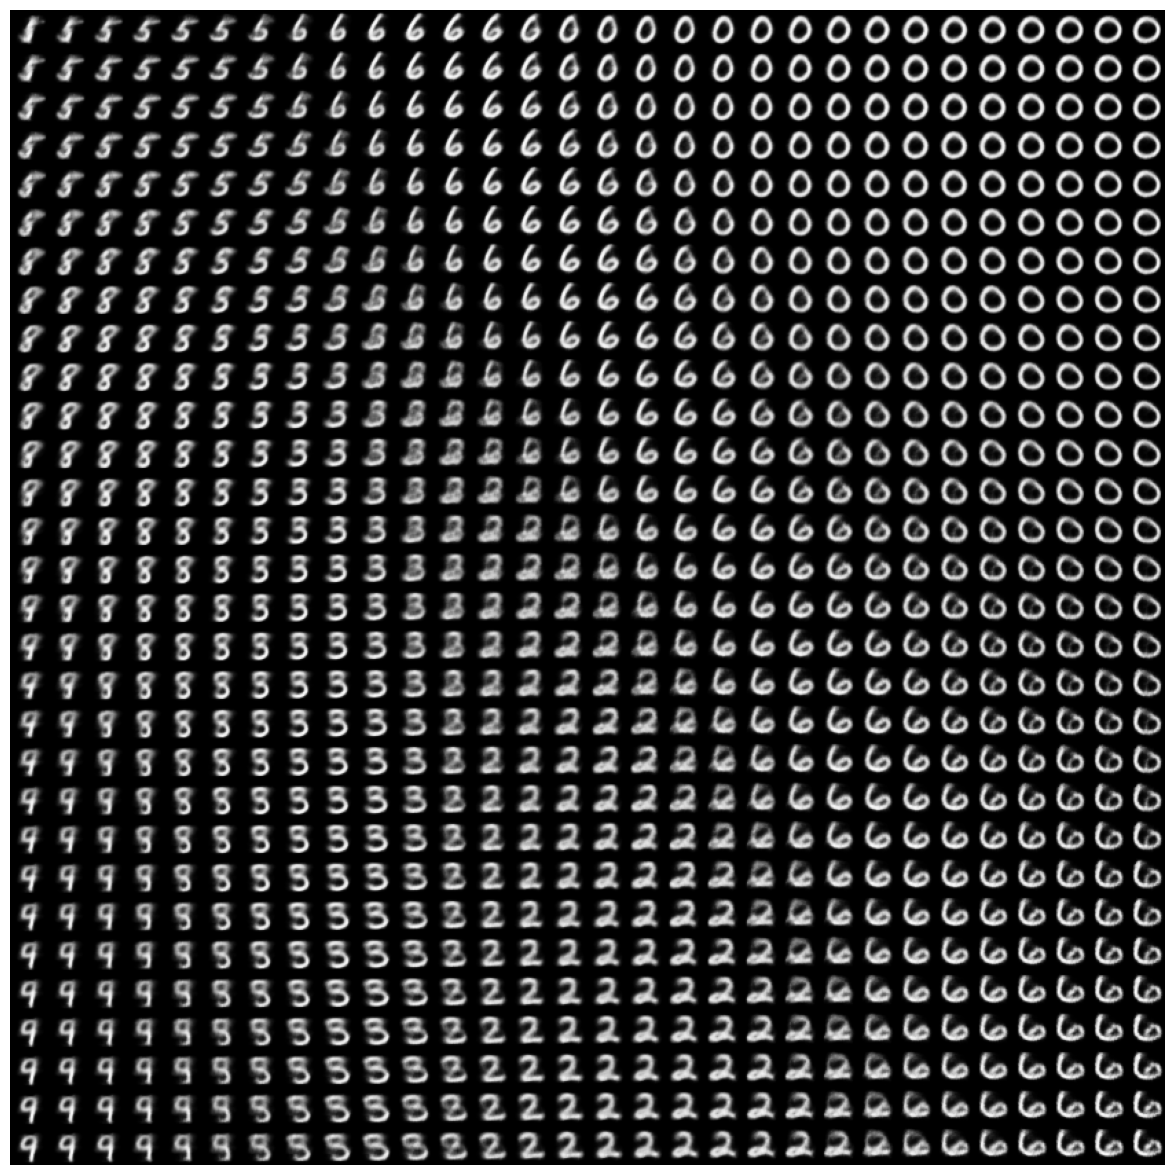

In [56]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

# Diffusion models

In [57]:
import os

fpath = keras.utils.get_file(
    origin="https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
    extract=True,
)

In [58]:
batch_size = 32
image_size = 128
images_dir = os.path.join(fpath, "jpg")
dataset = keras.utils.image_dataset_from_directory(
    images_dir,
    labels=None,
    image_size=(image_size, image_size),
    crop_to_aspect_ratio=True,
)
dataset = dataset.rebatch(
    batch_size,
    drop_remainder=True,
)

Found 8189 files.


In [59]:
def residual_block(x, width):
    input_width = x.shape[3]
    if input_width == width:
        residual = x
    else:
        residual = layers.Conv2D(width, 1)(x)
    x = layers.BatchNormalization(center=False, scale=False)(x)
    x = layers.Conv2D(width, 3, padding="same", activation="swish")(x)
    x = layers.Conv2D(width, 3, padding="same")(x)
    x = x + residual
    return x

def get_model(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_rates = keras.Input(shape=(1, 1, 1))

    x = layers.Conv2D(widths[0], 1)(noisy_images)
    n = layers.UpSampling2D(image_size, interpolation="nearest")(noise_rates)
    x = layers.Concatenate()([x, n])

    skips = []
    for width in widths[:-1]:
        for _ in range(block_depth):
            x = residual_block(x, width)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)

    for _ in range(block_depth):
        x = residual_block(x, widths[-1])

    for width in reversed(widths[:-1]):
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = residual_block(x, width)

    pred_noise_masks = layers.Conv2D(3, 1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_rates], pred_noise_masks)

In [60]:
def diffusion_schedule(
    diffusion_times,
    min_signal_rate=0.02,
    max_signal_rate=0.95,
):
    start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
    end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = ops.cos(diffusion_angles)
    noise_rates = ops.sin(diffusion_angles)
    return noise_rates, signal_rates

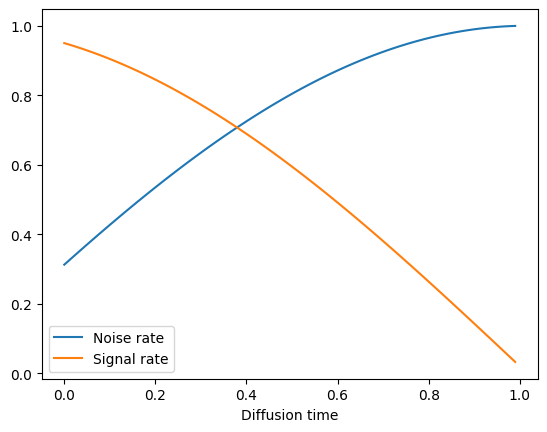

In [61]:
diffusion_times = ops.arange(0.0, 1.0, 0.01)
noise_rates, signal_rates = diffusion_schedule(diffusion_times)

diffusion_times = ops.convert_to_numpy(diffusion_times)
noise_rates = ops.convert_to_numpy(noise_rates)
signal_rates = ops.convert_to_numpy(signal_rates)

plt.plot(diffusion_times, noise_rates, label="Noise rate")
plt.plot(diffusion_times, signal_rates, label="Signal rate")

plt.xlabel("Diffusion time")
plt.legend()

In [62]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.denoising_model = get_model(image_size, widths, block_depth)
        self.seed_generator = keras.random.SeedGenerator()
        self.loss = keras.losses.MeanAbsoluteError()
        self.normalizer = keras.layers.Normalization()

    def denoise(self, noisy_images, noise_rates, signal_rates):
        pred_noise_masks = self.denoising_model([noisy_images, noise_rates])
        pred_images = (
            noisy_images - noise_rates * pred_noise_masks
        ) / signal_rates
        return pred_images, pred_noise_masks

    def call(self, images):
        images = self.normalizer(images)
        noise_masks = keras.random.normal(
            (batch_size, self.image_size, self.image_size, 3),
            seed=self.seed_generator,
        )
        diffusion_times = keras.random.uniform(
            (batch_size, 1, 1, 1),
            minval=0.0,
            maxval=1.0,
            seed=self.seed_generator,
        )
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noise_masks
        pred_images, pred_noise_masks = self.denoise(
            noisy_images, noise_rates, signal_rates
        )
        return pred_images, pred_noise_masks, noise_masks

    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        _, pred_noise_masks, noise_masks = y_pred
        return self.loss(noise_masks, pred_noise_masks)
    def generate(self, num_images, diffusion_steps):
        noisy_images = keras.random.normal(
            (num_images, self.image_size, self.image_size, 3),
            seed=self.seed_generator,
        )
        step_size = 1.0 / diffusion_steps
        for step in range(diffusion_steps):
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)
            pred_images, pred_noises = self.denoise(
                noisy_images, noise_rates, signal_rates
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = diffusion_schedule(
                next_diffusion_times
            )
            noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        images = (
            self.normalizer.mean + pred_images * self.normalizer.variance**0.5
        )
        return ops.clip(images, 0.0, 255.0)

In [63]:
class VisualizationCallback(keras.callbacks.Callback):
    def __init__(self, diffusion_steps=20, num_rows=3, num_cols=6):
        self.diffusion_steps = diffusion_steps
        self.num_rows = num_rows
        self.num_cols = num_cols

    def on_epoch_end(self, epoch=None, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_rows * self.num_cols,
            diffusion_steps=self.diffusion_steps,
        )

        plt.figure(figsize=(self.num_cols * 2.0, self.num_rows * 2.0))
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                i = row * self.num_cols + col
                plt.subplot(self.num_rows, self.num_cols, i + 1)
                img = ops.convert_to_numpy(generated_images[i]).astype("uint8")
                plt.imshow(img)
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

In [64]:
model = DiffusionModel(image_size, widths=[32, 64, 96, 128], block_depth=2)
model.normalizer.adapt(dataset)

In [65]:
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=keras.optimizers.schedules.InverseTimeDecay(
            initial_learning_rate=1e-3,
            decay_steps=1000,
            decay_rate=0.1,
        ),
        use_ema=True,
        ema_overwrite_frequency=100,
    ),
)

Epoch 1/100
    255/Unknown 32s 84ms/step - loss: 0.5214

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


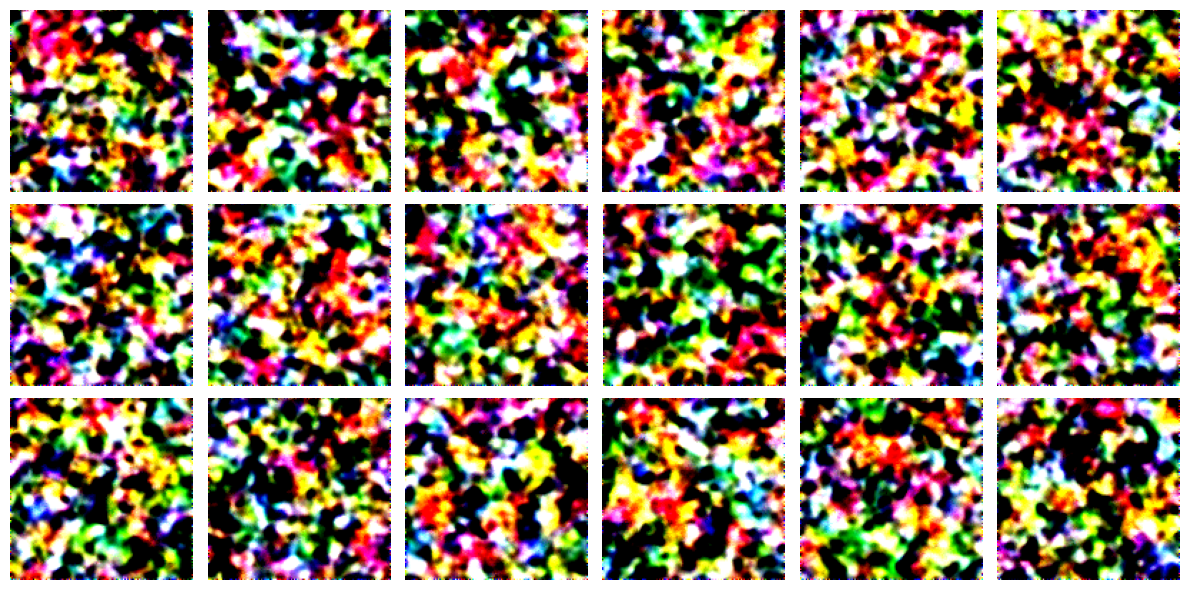

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


255/255 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - loss: 0.5066
Epoch 2/100
228/255 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2258

In [ ]:
model.fit(
    dataset,
    epochs=100,
    callbacks=[
        VisualizationCallback(),
        keras.callbacks.ModelCheckpoint(
            filepath="diffusion_model.weights.h5",
            save_weights_only=True,
            save_best_only=True,
        ),
    ],
)

In [ ]:
import keras_hub

height, width = 512, 512
task = keras_hub.models.TextToImage.from_preset(
    "stable_diffusion_3_medium",
    image_shape=(height, width, 3),
    dtype="float16",
)
prompt = "A NASA astraunaut riding an origami elephant in New York City"
task.generate(prompt)

In [ ]:
task.generate(
    {
        "prompts": prompt,
        "negative_prompts": "blue color",
    }
)

In [ ]:
import numpy as np
from PIL import Image

def display(images):
    return Image.fromarray(np.concatenate(images, axis=1))

display([task.generate(prompt, num_steps=x) for x in [5, 10, 15, 20, 25]])

In [ ]:
from keras import random

def get_text_embeddings(prompt):
    token_ids = task.preprocessor.generate_preprocess([prompt])
    negative_token_ids = task.preprocessor.generate_preprocess([""])
    return task.backbone.encode_text_step(token_ids, negative_token_ids)

def denoise_with_text_embeddings(embeddings, num_steps=28, guidance_scale=7.0):
    latents = random.normal((1, height // 8, width // 8, 16))
    for step in range(num_steps):
        latents = task.backbone.denoise_step(
            latents,
            embeddings,
            step,
            num_steps,
            guidance_scale,
        )
    return task.backbone.decode_step(latents)[0]

def scale_output(x):
    x = np.clip((x + 1.0) / 2.0, 0.0, 1.0)
    return np.round(x * 255.0).astype("uint8")

embeddings = get_text_embeddings(prompt)
image = denoise_with_text_embeddings(embeddings)
scale_output(image)

In [ ]:
[x.shape for x in embeddings]

In [ ]:
from keras import ops

def slerp(t, v1, v2):
    v1, v2 = ops.cast(v1, "float32"), ops.cast(v2, "float32")
    v1_norm = ops.linalg.norm(ops.ravel(v1))
    v2_norm = ops.linalg.norm(ops.ravel(v2))
    dot = ops.sum(v1 * v2 / (v1_norm * v2_norm))
    theta_0 = ops.arccos(dot)
    sin_theta_0 = ops.sin(theta_0)
    theta_t = theta_0 * t
    sin_theta_t = ops.sin(theta_t)
    s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    return s0 * v1 + s1 * v2

def interpolate_text_embeddings(e1, e2, start=0, stop=1, num=10):
    embeddings = []
    for t in np.linspace(start, stop, num):
        embeddings.append(
            (
                slerp(t, e1[0], e2[0]),
                e1[1],
                slerp(t, e1[2], e2[2]),
                e1[3],
            )
        )
    return embeddings

In [ ]:
prompt1 = "A friendly dog looking up in a field of flowers"
prompt2 = "A horrifying, tentacled creature hovering over a field of flowers"
e1 = get_text_embeddings(prompt1)
e2 = get_text_embeddings(prompt2)

images = []
for et in interpolate_text_embeddings(e1, e2, start=0.5, stop=0.6, num=9):
    image = denoise_with_text_embeddings(et)
    images.append(scale_output(image))
display(images)